In [2]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox")
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("data/cleaned_data/cross_val_split.pkl", "rb") as read_file:
    folds = pickle.load(read_file)

In [4]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.02, step=0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['eval_metric'] = 'MultiRMSE'
    param['loss_function'] = 'MultiRMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 1
    param['logging_level'] = 'Silent'

    regressor = CatBoostRegressor(**param)
    losses = []
    for fold in folds:
        regressor.fit(fold["Train X scaled embeddings"], fold["Train y multi share"], early_stopping_rounds=100)
        losses.append(mean_squared_error(fold["Test y multi share"], regressor.predict(fold["Test X scaled embeddings"]), squared=False))

    return np.mean(losses)

In [5]:
study = optuna.create_study()
study.optimize(objective, n_trials=200)

[I 2023-01-30 12:08:21,832] A new study created in memory with name: no-name-2e39fbc9-6ed1-41d2-b712-a1056a2a18de
[I 2023-01-30 12:17:58,076] Trial 0 finished with value: 0.15087582126215465 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 13, 'l2_leaf_reg': 5.5, 'min_child_samples': 4}. Best is trial 0 with value: 0.15087582126215465.
[I 2023-01-30 12:20:30,896] Trial 1 finished with value: 0.19079048130240306 and parameters: {'learning_rate': 0.001, 'depth': 9, 'l2_leaf_reg': 4.0, 'min_child_samples': 16}. Best is trial 0 with value: 0.15087582126215465.
[I 2023-01-30 12:25:23,669] Trial 2 finished with value: 0.1853720962126444 and parameters: {'learning_rate': 0.001, 'depth': 11, 'l2_leaf_reg': 1.0, 'min_child_samples': 8}. Best is trial 0 with value: 0.15087582126215465.
[I 2023-01-30 12:26:40,666] Trial 3 finished with value: 0.14600260139965965 and parameters: {'learning_rate': 0.004, 'depth': 14, 'l2_leaf_reg': 4.5, 'min_child_samples': 32}. Best is trial 3 with

KeyboardInterrupt: 

In [6]:
study.best_params

{'learning_rate': 0.019000000000000003,
 'depth': 13,
 'l2_leaf_reg': 1.5,
 'min_child_samples': 16}

In [7]:
def detailed_objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_float("learning_rate", 0.001, 0.02, step=0.001)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.5, step=0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['eval_metric'] = 'MultiRMSE'
    param['loss_function'] = 'MultiRMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = 1
    param['logging_level'] = 'Silent'

    regressor = CatBoostRegressor(**param)
    rmse_losses = []
    mae_losses = []
    r2_scores = []
    for fold in folds:
        regressor.fit(fold["Train X scaled embeddings"], fold["Train y multi share"], early_stopping_rounds=100)
        rmse_losses.append(mean_squared_error(fold["Test y multi share"], regressor.predict(fold["Test X scaled embeddings"]), squared=False))
        mae_losses.append(mean_absolute_error(fold["Test y multi share"], regressor.predict(fold["Test X scaled embeddings"])))
        r2_scores.append(r2_score(fold["Test y multi share"], regressor.predict(fold["Test X scaled embeddings"])))

    rmse = np.mean(rmse_losses)
    mae = np.mean(mae_losses)
    r2 = np.mean(r2_scores)

    return rmse, mae, r2

In [8]:
eval_metrics = detailed_objective(study.best_trial)

In [9]:
print(f"Best parameters: {study.best_params}")
print(f"Root Mean Squared Error: {round(eval_metrics[0], 3)}")
print(f"Mean Absolute Error: {round(eval_metrics[1], 3)}")
print(f"R2 score: {round(eval_metrics[2], 3)}")

Best parameters: {'learning_rate': 0.019000000000000003, 'depth': 13, 'l2_leaf_reg': 1.5, 'min_child_samples': 16}
Root Mean Squared Error: 0.135
Mean Absolute Error: 0.104
R2 score: 0.663


In [37]:
param = {}
param['learning_rate'] = 0.018
param['depth'] = 12
param['l2_leaf_reg'] = 1.5
param['min_child_samples'] = 32
param['grow_policy'] = 'Depthwise'
param['eval_metric'] = 'MultiRMSE'
param['loss_function'] = 'MultiRMSE'
param['od_type'] = 'iter'
param['od_wait'] = 20
param['random_state'] = 1
param['logging_level'] = 'Silent'


regressor = CatBoostRegressor(**param)
losses = []
for fold in folds[:-1]:
    regressor.fit(fold["Train X scaled embeddings"], fold["Train y multi share"], early_stopping_rounds=100)
    losses.append(mean_squared_error(fold["Test y multi share"], regressor.predict(fold["Test X scaled embeddings"]), squared=False))

np.mean(losses)

0.12916769635538702

In [38]:
print(losses)

[0.11814883027798379, 0.16082595739418193, 0.09224596764467823, 0.16342807931674652, 0.0865745477434926, 0.16185881799096402, 0.10249677034221466, 0.14103122883589853, 0.13589906765232282]


In [39]:
test_set = folds[-1]
regressor.fit(test_set["Train X scaled embeddings"], test_set["Train y multi share"], early_stopping_rounds=100)
mean_squared_error(test_set["Test y multi share"], regressor.predict(test_set["Test X scaled embeddings"]), squared=False)

0.13863820930336873

In [40]:
mae = mean_absolute_error(test_set["Test y multi share"], regressor.predict(test_set["Test X scaled embeddings"]))
r2 = r2_score(test_set["Test y multi share"], regressor.predict(test_set["Test X scaled embeddings"]))

In [41]:
mae

0.0917287243253807

In [42]:
r2

0.7260485751146506

In [43]:
predictions = regressor.predict(test_set["Test X scaled embeddings"])
predictions

array([[0.84102695, 0.12845775],
       [0.8984991 , 0.08571232],
       [0.64692423, 0.33607303],
       [0.71652194, 0.2615663 ],
       [0.93843416, 0.04411711],
       [0.75878067, 0.22792929],
       [0.98343074, 0.00426076],
       [0.51279638, 0.47021415],
       [0.97733802, 0.0073756 ],
       [0.95682602, 0.02754056],
       [0.53338059, 0.43564703],
       [0.55452044, 0.41632486],
       [0.61968251, 0.3586454 ],
       [0.87240938, 0.10944823],
       [0.60052358, 0.38282093],
       [0.95471576, 0.03929849],
       [0.53814706, 0.44098276]])

In [44]:
test_labels = []
for m_share, _ in test_set["Test y multi share"]:
    if m_share < 0.3:
        label = "F"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "M"
    test_labels.append(label)

In [45]:
list(zip(test_set["Test y classes"], test_labels))

[(2, 'M'),
 (2, 'M'),
 (1, 'F'),
 (2, 'M'),
 (2, 'M'),
 (2, 'M'),
 (2, 'M'),
 (0, 'N'),
 (2, 'M'),
 (2, 'M'),
 (0, 'N'),
 (0, 'N'),
 (0, 'N'),
 (2, 'M'),
 (0, 'N'),
 (2, 'M'),
 (0, 'N')]

In [46]:
predicted_labels_male_share = []
for m_share, _ in predictions:
    if m_share < 0.3:
        label = "F"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "M"
    predicted_labels_male_share.append(label)

In [47]:
predicted_labels_female_share = []
for _, f_share in predictions:
    if f_share < 0.3:
        label = "M"
    elif m_share < 0.7:
        label = "N"
    else:
        label = "F"
    predicted_labels_female_share.append(label)

In [48]:
list(zip(predicted_labels_male_share, predicted_labels_female_share))

[('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('M', 'M'),
 ('M', 'M'),
 ('N', 'N'),
 ('N', 'N'),
 ('N', 'N'),
 ('M', 'M'),
 ('N', 'N'),
 ('M', 'M'),
 ('N', 'N')]

In [49]:
acc = accuracy_score(predicted_labels_male_share, test_labels)
recall = recall_score(predicted_labels_male_share, test_labels, average="weighted")
precision = precision_score(predicted_labels_male_share, test_labels, average="weighted")
f1 = f1_score(predicted_labels_male_share, test_labels, average="weighted")

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print("Classification by converting predicted shares from CatBoostRegressor (multioutput) to labels:")
print(f"Score: {round(acc, 3)}")
print(f"F1: {round(f1, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"Precision: {round(precision, 3)}")

Classification by converting predicted shares from CatBoostRegressor (multioutput) to labels:
Score: 0.941
F1: 0.968
Recall: 0.941
Precision: 1.0


In [51]:
cm = confusion_matrix(y_true=test_labels, y_pred=predicted_labels_male_share, labels=["N", "F", "M"])

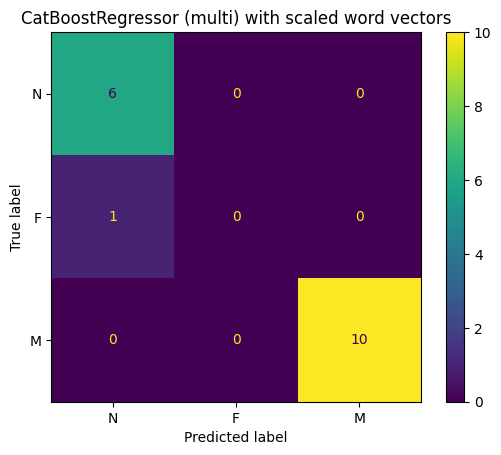

In [52]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "F", "M"])
plot.plot()
plt.title("CatBoostRegressor (multi) with scaled word vectors")
plt.show()